# P1

In [1]:
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from skimage.exposure import equalize_hist
from skimage.filters import gaussian

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5318782546955116341
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 9168103015
locality {
  bus_id: 1
}
incarnation: 8577352799212993930
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 6228:00:00.0"
]


In [3]:
batch_size = 256
size = 80
shape =  2 * (size,)

# Preprocessing

In [4]:
X, y = shuffle(np.load('../../data/pml/x_train.npy'), np.load('../../data/pml/y_train.npy'))
data_test = np.load('../../data/pml/x_test.npy')

In [5]:
X[0].reshape(shape)

array([[0.13244104, 0.10377189, 0.11684909, ..., 0.71267936, 0.7659698 ,
        0.78391098],
       [0.12232404, 0.10978525, 0.08829099, ..., 0.66137904, 0.76437605,
        0.7850464 ],
       [0.0819651 , 0.09034599, 0.1887449 , ..., 0.68635453, 0.76989137,
        0.77690118],
       ...,
       [0.48452706, 0.41475614, 0.41979974, ..., 0.7368898 , 0.75843216,
        0.76964627],
       [0.46718093, 0.44976194, 0.42340449, ..., 0.73681451, 0.75451059,
        0.77218836],
       [0.468739  , 0.45432654, 0.46214525, ..., 0.73360855, 0.75451059,
        0.76787054]])

In [19]:
data_test[0].reshape(shape)

array([[ 1.75664719,  1.83274157,  1.90551943, ..., -1.09509472,
        -1.09157223, -1.07768264],
       [ 1.78652647,  1.86673155,  1.94396503, ..., -1.09206242,
        -1.08522248, -1.07207491],
       [ 1.81424616,  1.90392544,  1.98948938, ..., -1.0893651 ,
        -1.07942912, -1.06460761],
       ...,
       [ 0.76911551,  0.81539227,  0.8629608 , ..., -0.86640501,
        -0.91538183, -0.93473806],
       [ 0.61000505,  0.66260806,  0.76606595, ..., -0.90774919,
        -0.95238819, -0.96548936],
       [ 0.55880554,  0.61260197,  0.76274978, ..., -0.93871324,
        -0.97685704, -0.98348395]])

In [6]:
def prepare(img):
    img = img.reshape(shape)
    img = equalize_hist(img)
    img = gaussian(img, sigma=1)
    img - img.mean()
    
    return img.flatten()
    
def transform(X):
    height, width = X.shape
    for i in range(height):
        X[i] = prepare(X[i]) 
        
    return X
X = transform(X)
data_test = transform(data_test)

In [7]:
d=np.concatenate((X,data_test))
d.shape

(2308, 6400)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(d)
X=scaler.transform(X)
data_test=scaler.transform(data_test)

In [9]:
X=X.reshape(X.shape[0], size,size,1)
data_test=data_test.reshape(data_test.shape[0], size,size,1)
X.shape,data_test.shape

((1716, 80, 80, 1), (592, 80, 80, 1))

# Train images

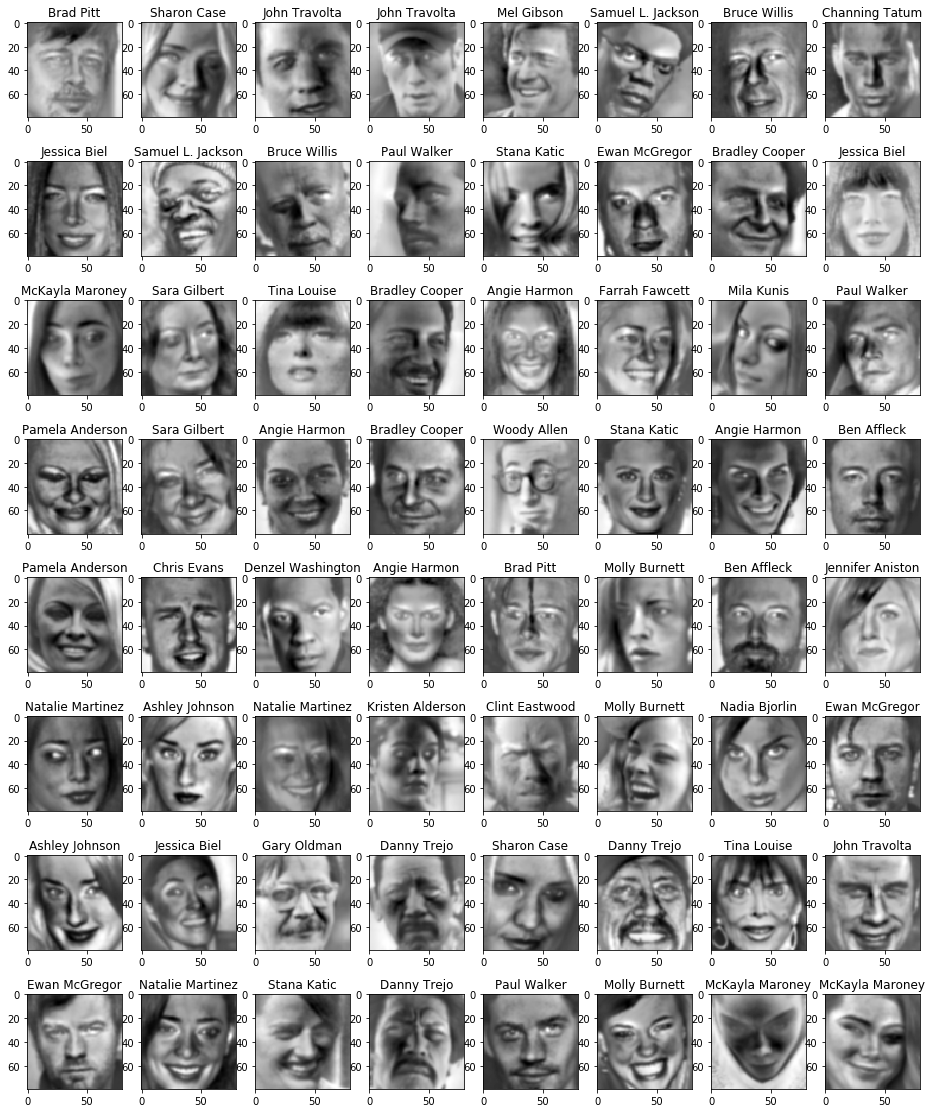

In [10]:
width, height = 8, 8

plt.figure(figsize=(16, 20))
for n, (image, name) in enumerate(zip(X, y), 1):
    if n > width * height:
        break
    
    plt.subplot(height, width, n)
    plt.title(name)
    plt.imshow(image.reshape(shape), cmap='gray')

# Test images

In [ ]:
width, height = 8, 8

plt.figure(figsize=(16, 20))
n=1
for image in data_test:
    if n > width * height:
        break
    
    plt.subplot(height, width, n)
    plt.imshow(image.reshape(shape), cmap='gray')
    n+=1

In [11]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
le=LabelEncoder()
y_transform=le.fit_transform(y)
lb=LabelBinarizer()
y_lb=lb.fit_transform(y_transform)

# Training

In [12]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, y_lb, test_size=0.4, random_state=0)

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Skip 

for n, (image, name) in enumerate(zip(X, y_transform), 1):
    t=str(name)
    if not os.path.exists(train_data_dir+t):
        os.makedirs(train_data_dir+t)
    if not os.path.exists(validation_data_dir+t):
        os.makedirs(validation_data_dir+t)
    if not os.path.exists(test_data_dir+t):
        os.makedirs(test_data_dir+t)

for n, (image, name) in enumerate(zip(trainX,trainY), 1):
    i=0
    x1=image.reshape((1,size,size,1))
    for batch in datagen.flow(x1, batch_size=1,
                              save_to_dir=f'{train_data_dir}{str(name)}', save_prefix=str(name), save_format='jpeg'):
        i += 1
        if i > 10:
            break  # otherwise the generator would loop indefinitely

for n, (image, name) in enumerate(zip(testX,testY), 1):
    i=0
    x1=image.reshape((1,size,size,1))
    for batch in datagen.flow(x1, batch_size=1,
                              save_to_dir=f'{validation_data_dir}{str(name)}', save_prefix=str(name), save_format='jpeg'):
        i += 1
        if i > 10:
            break  # otherwise the generator would loop indefinitely

In [13]:
trainX.shape, testX.shape

((1029, 80, 80, 1), (687, 80, 80, 1))

X = X.astype('float32')
X/=255

plt.figure()
plt.imshow(X[0].reshape(shape))
plt.colorbar()
plt.grid(False)
plt.show()

X = X.reshape(X.shape[0], size, size, 1)
X.shape

from keras.utils.np_utils import to_categorical
y_binary = to_categorical(y_transform)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D 
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical

Using TensorFlow backend.


In [15]:
def createModel():
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(size, size, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (2, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (2, 2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(40, activation='softmax'))
    
    return model

In [16]:
my_network = createModel()

In [17]:
import keras
batch_size = 128
epochs = 40

my_network.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(),
                   metrics=['accuracy'])
print('The crash is right after this')
history = my_network.fit(trainX, trainY, batch_size=batch_size, epochs=epochs, validation_data=(testX, testY))
my_network.evaluate(testX, testY)

The crash is right after this
Train on 1029 samples, validate on 687 samples
Epoch 1/40
1029/1029 [==============================] - 3s - loss: 4.1040 - acc: 0.0340 - val_loss: 3.6817 - val_acc: 0.0451
Epoch 2/40
1029/1029 [==============================] - 1s - loss: 3.6479 - acc: 0.0447 - val_loss: 3.6472 - val_acc: 0.0626
Epoch 3/40
1029/1029 [==============================] - 1s - loss: 3.6268 - acc: 0.0486 - val_loss: 3.6498 - val_acc: 0.09610.05
Epoch 4/40
1029/1029 [==============================] - 1s - loss: 3.5090 - acc: 0.0768 - val_loss: 3.5562 - val_acc: 0.1354
Epoch 5/40
1029/1029 [==============================] - 1s - loss: 3.4218 - acc: 0.0952 - val_loss: 3.4473 - val_acc: 0.1048
Epoch 6/40
1029/1029 [==============================] - 1s - loss: 3.3616 - acc: 0.1147 - val_loss: 3.3196 - val_acc: 0.1383
Epoch 7/40
1029/1029 [==============================] - 1s - loss: 3.3105 - acc: 0.1176 - val_loss: 3.3628 - val_acc: 0.1514
Epoch 8/40
1029/1029 [======================

[1.7877467285944733, 0.5633187778999018]

In [18]:
my_network.save_weights('try_5.h5')

In [20]:
prediction= my_network.predict(data_test)

In [21]:
prediction

array([[1.8219337e-02, 2.0247592e-02, 5.2014091e-03, ..., 2.4895888e-02,
        1.0243452e-02, 2.3679254e-03],
       [1.7769223e-04, 7.4041472e-04, 6.7192793e-02, ..., 1.6390489e-02,
        3.5827481e-03, 1.8070413e-04],
       [9.8585151e-04, 1.4415914e-03, 1.5323448e-02, ..., 3.4803513e-02,
        2.2084438e-03, 5.4941771e-05],
       ...,
       [1.8386696e-05, 1.7408763e-01, 1.9175484e-04, ..., 1.2181927e-04,
        7.1888324e-04, 2.9530491e-07],
       [1.3719093e-04, 4.1361889e-03, 1.0095692e-03, ..., 1.2385470e-04,
        1.3598239e-03, 6.6280169e-05],
       [3.6094553e-07, 2.1727629e-04, 6.5961558e-07, ..., 3.2577025e-06,
        1.2430723e-06, 3.1389153e-12]], dtype=float32)

In [22]:
y_classes = [np.argmax(y, axis=None, out=None) for y in prediction]
y_classes

[8,
 21,
 26,
 28,
 25,
 0,
 33,
 12,
 30,
 36,
 3,
 5,
 17,
 28,
 4,
 36,
 30,
 7,
 8,
 34,
 24,
 11,
 34,
 36,
 5,
 22,
 13,
 12,
 35,
 38,
 23,
 19,
 27,
 36,
 22,
 30,
 27,
 37,
 24,
 34,
 39,
 38,
 34,
 1,
 38,
 27,
 1,
 14,
 29,
 25,
 27,
 11,
 36,
 32,
 13,
 29,
 1,
 1,
 29,
 21,
 22,
 3,
 8,
 28,
 23,
 12,
 38,
 33,
 24,
 26,
 28,
 34,
 22,
 17,
 27,
 38,
 24,
 30,
 34,
 29,
 33,
 27,
 9,
 37,
 34,
 20,
 27,
 28,
 13,
 5,
 34,
 17,
 1,
 33,
 24,
 37,
 34,
 16,
 13,
 24,
 18,
 12,
 2,
 33,
 30,
 29,
 30,
 15,
 7,
 21,
 35,
 32,
 21,
 34,
 7,
 38,
 34,
 36,
 21,
 15,
 15,
 19,
 38,
 16,
 38,
 26,
 9,
 27,
 15,
 6,
 1,
 38,
 22,
 24,
 1,
 1,
 23,
 39,
 38,
 37,
 6,
 27,
 2,
 35,
 34,
 8,
 16,
 12,
 39,
 26,
 29,
 12,
 27,
 36,
 36,
 4,
 25,
 36,
 1,
 34,
 22,
 34,
 4,
 27,
 4,
 30,
 27,
 5,
 29,
 30,
 25,
 16,
 14,
 23,
 7,
 24,
 12,
 33,
 27,
 18,
 6,
 31,
 9,
 21,
 27,
 22,
 30,
 20,
 17,
 20,
 3,
 16,
 36,
 28,
 32,
 24,
 24,
 16,
 28,
 16,
 2,
 39,
 36,
 34,
 3,
 33,
 3,
 6,
 

In [23]:
preds=le.inverse_transform(y_classes)
preds

array(['Channing Tatum', 'Kristen Alderson', 'Mila Kunis',
       'Nadia Bjorlin', 'Mel Gibson', 'Al Pacino', 'Samuel L. Jackson',
       'Denzel Washington', 'Pamela Anderson', 'Sharon Case',
       'Ashley Johnson', 'Brad Pitt', 'Jennifer Aniston', 'Nadia Bjorlin',
       'Ben Affleck', 'Sharon Case', 'Pamela Anderson', 'Bruce Willis',
       'Channing Tatum', 'Sara Gilbert', 'McKayla Maroney', 'Danny Trejo',
       'Sara Gilbert', 'Sharon Case', 'Brad Pitt', 'Lea Michele',
       'Ewan McGregor', 'Denzel Washington', 'Selena Gomez',
       'Tina Louise', 'Matt Damon', 'John Travolta', 'Molly Burnett',
       'Sharon Case', 'Lea Michele', 'Pamela Anderson', 'Molly Burnett',
       'Stana Katic', 'McKayla Maroney', 'Sara Gilbert', 'Woody Allen',
       'Tina Louise', 'Sara Gilbert', 'Angie Harmon', 'Tina Louise',
       'Molly Burnett', 'Angie Harmon', 'Farrah Fawcett',
       'Natalie Martinez', 'Mel Gibson', 'Molly Burnett', 'Danny Trejo',
       'Sharon Case', 'Robin Williams', 'Ew

In [24]:
with open('prediction2.csv', 'w') as out:
    print('Id,Name', file=out)
    for pair in enumerate(preds, 1):
        print('%i,%s' % pair, file=out)